In [2]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from algorithm import fluid_communities

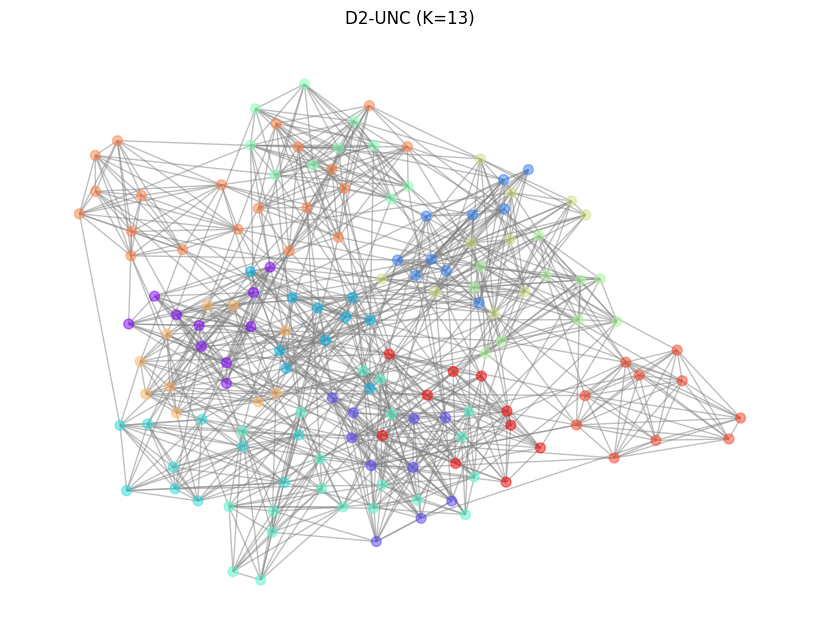

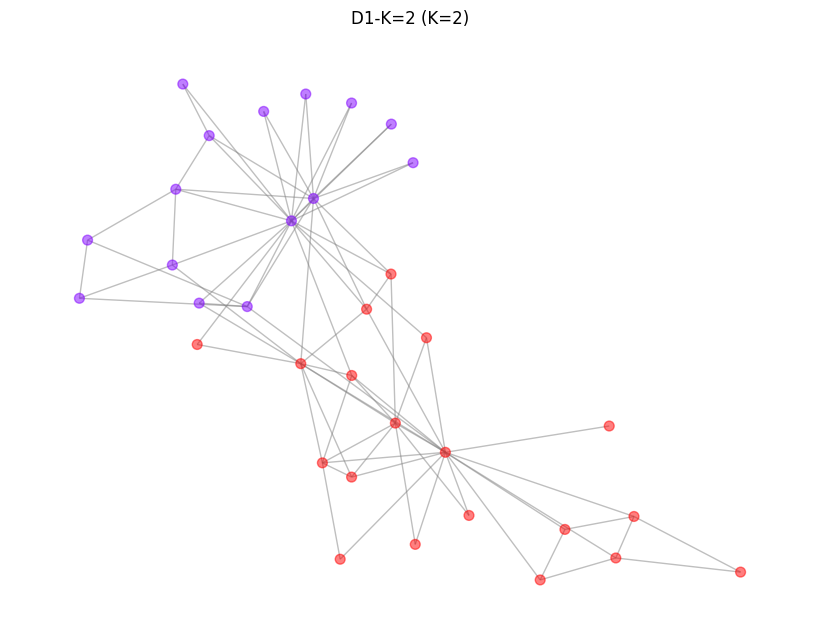

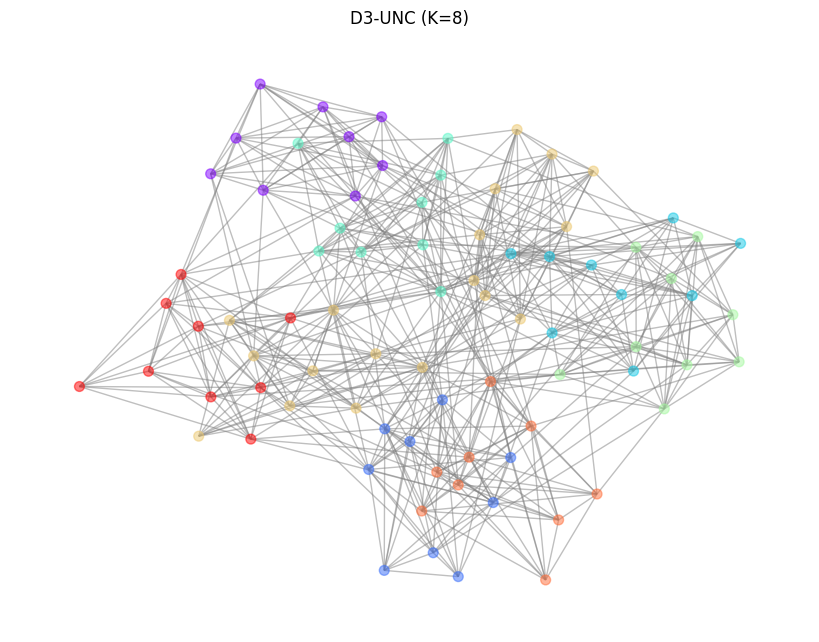

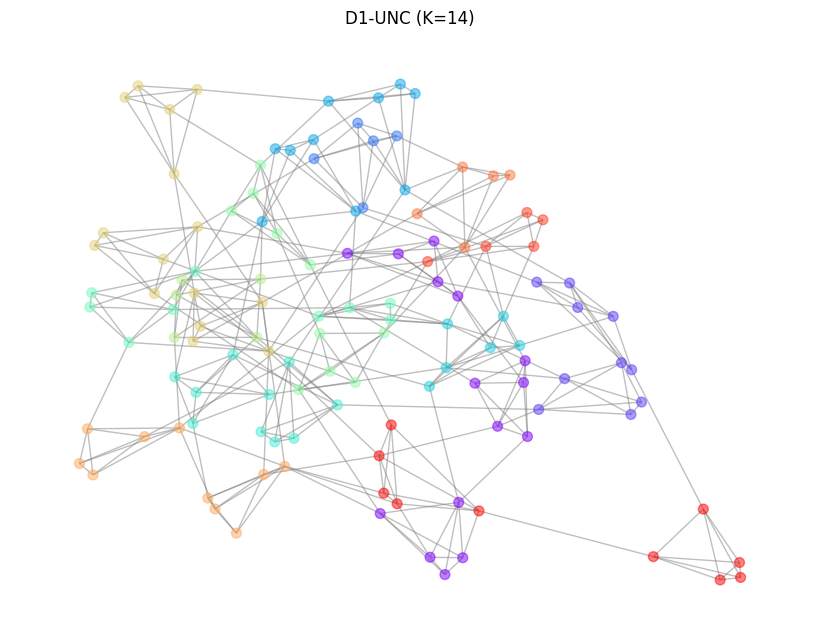

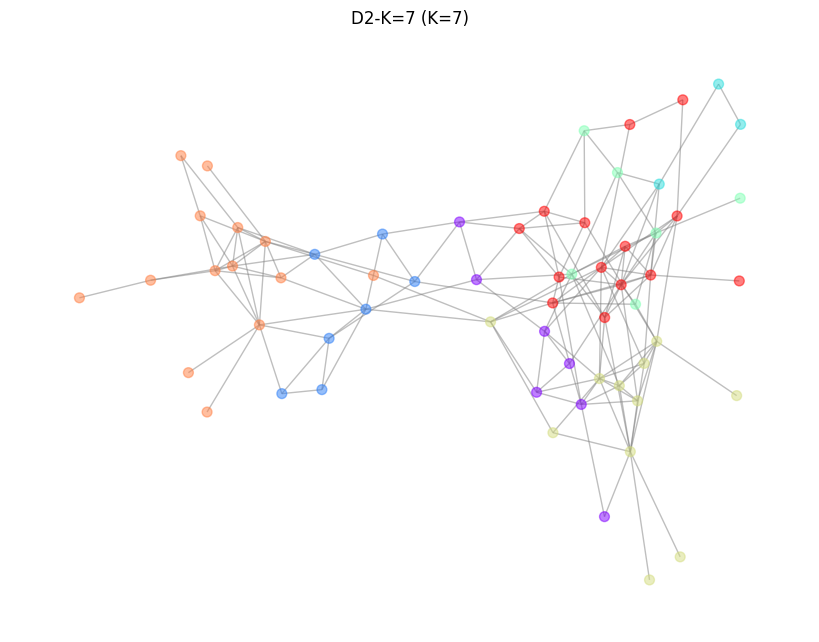

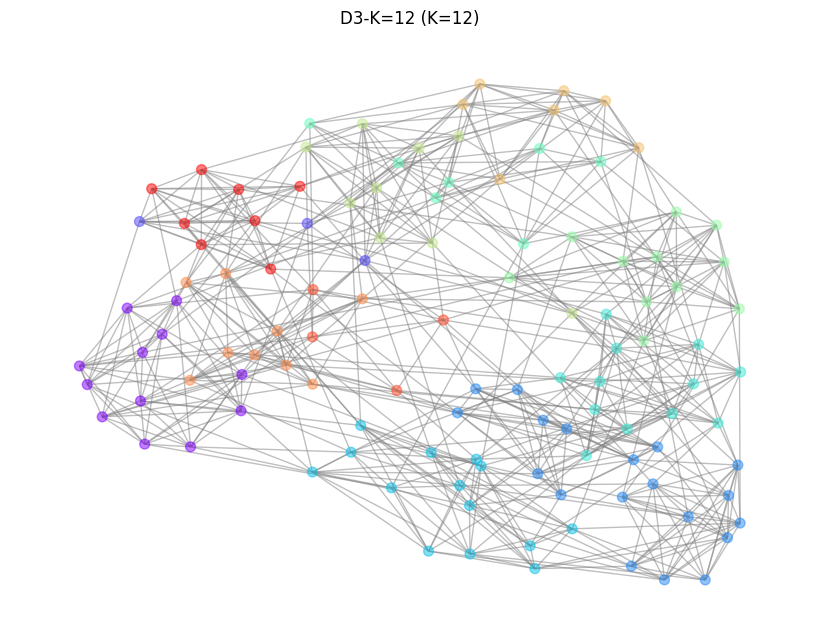

In [6]:
graph_files = [f for f in os.listdir("competition") if f.endswith(".csv")]

for file_name in graph_files:
    path = os.path.join("competition", file_name)
    prefix = file_name.replace(".csv", "")
    
    try:
        df_adj = pd.read_csv(path, header=None)
        G = nx.from_pandas_adjacency(df_adj)
    except:
        continue

    if "K=" in file_name:
        k_value = int(file_name.split("K=")[1].split(".")[0])
    else:
        best_mod = -1
        k_value = 2
        for k_test in range(2, 15):
            mapping = fluid_communities(G, k_test)
            comms = {}
            for n, c in mapping.items():
                comms.setdefault(c, set()).add(n)
            mod = nx.community.modularity(G, list(comms.values()))
            if mod > best_mod:
                best_mod = mod
                k_value = k_test

    full_mapping = {}
    comm_offset = 0
    for comp_nodes in nx.connected_components(G):
        subG = G.subgraph(comp_nodes).copy()
        comp_k = max(1, round(k_value * (len(comp_nodes) / G.number_of_nodes())))
        comp_k = min(comp_k, len(comp_nodes))
        comp_mapping = fluid_communities(subG, comp_k)
        for node, cid in comp_mapping.items():
            if cid is not None:
                full_mapping[node] = cid + comm_offset
        comm_offset += comp_k

    pd.DataFrame(list(full_mapping.items())).sort_values(0).to_csv(f"result/{prefix}.csv", header=False, index=False)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    colors = [full_mapping[n] for n in G.nodes()]
    nx.draw(G, pos, node_color=colors, node_size=50, cmap=plt.cm.rainbow, with_labels=False, edge_color='gray', alpha=0.5)
    plt.title(f"{prefix} (K={k_value})")
    plt.show()